In [1]:
# %load_ext autoreload
# %autoreload 2
# from nn.value import Value
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
from nn.value import Value, exp, log
from nn.module import Layer,MLP, Relu, Tanh, Softmax

%matplotlib inline
np.random.seed(1337)
random.seed(1337)

# Regression

In [2]:
from sklearn.datasets import make_regression
X, y = X_raw, y_raw = make_regression(n_samples=50, n_features=10)
y = (y-y.mean()) / y.std()

In [3]:
# FIXME something seems wrong with tanh? multi-layer breaks...  maybe some under/overflow?
net = MLP(10, [16, 1], act=Relu)

In [23]:
X=[[x_ for x_ in x]for x in X_raw]
batch_size = len(X)
lr = .5

for i in range(30):
    #forward
    y_logits = [net(x) for x in X]

    loss = sum((y1-y2)**2  for y1, y2 in zip(y_logits, y)) / batch_size
    loss = loss[0]

    #backward
    for v in loss.topo_sort():
        v.grad = 0

    loss.backward()
    # print(mlp.parameters())
    if i%10 ==0:
        print(i, 'loss', loss.data, 'lr', lr)#, 'reg_loss', reg_loss.data)
    # for p in net.parameters():
    #     print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')

    if i%10 ==0:
        lr = max(lr / 1.1, 1e-3)
    
    for p in net.parameters():
        p.data -= p.grad * lr

0 loss 1.1161323272153605 lr 0.5
10 loss 0.09419226188673857 lr 0.45454545454545453
20 loss 0.27753784564816 lr 0.4132231404958677
30 loss 0.0902916264824883 lr 0.3756574004507888
40 loss 0.015998810257643322 lr 0.34150672768253526
50 loss 0.00608089016647188 lr 0.31046066152957746
60 loss 0.004790507411662123 lr 0.28223696502688855
70 loss 0.003976928917902704 lr 0.2565790591153532
80 loss 0.003412683623330242 lr 0.23325369010486655
90 loss 0.003002841310228318 lr 0.2120488091862423


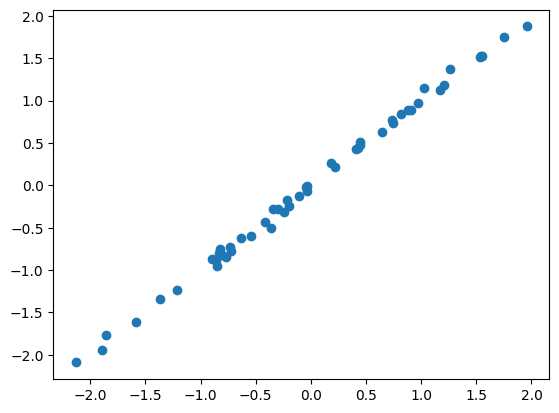

In [25]:
y_pred = [[y_.data for y_ in y] for y in y_logits]
plt.scatter(y_pred, y)

# Classification

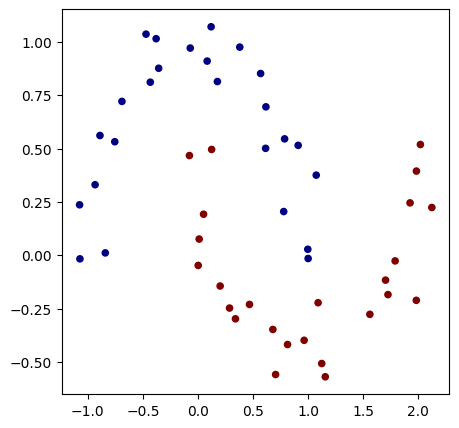

In [15]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X_raw, y_raw = X, y = make_moons(n_samples=50, noise=0.1)

# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [16]:
# multi-layer doesn't work yet...
net = MLP(2, [16,2], act=Relu)

In [19]:
batch_size = len(X)
lr = 1

def flatten(x):
    return [x__ for x_ in x for x__ in x_]
    
for i in range(100):
    #forward
    y_logits = [net(x) for x in X]
    y_probs = [Softmax()(x) for x in y_logits]

    # nll loss
    nll_loss = sum(-log(y_probs_[y_true]) for y_probs_, y_true in zip(y_probs, y)) / batch_size
    # L2
    # reg_loss = 1e-3 * sum(p**2 for p in net.parameters()) / batch_size
    loss = nll_loss #+ reg_loss

    #backward
    # for p in net.parameters() + flatten(y_logits) + flatten(y_probs):
    #     p.grad = 0
    for v in loss.topo_sort():
        v.grad = 0

    loss.backward()
    # break
    # print(mlp.parameters())
    # if i==0 or i % 10 == 0:
    
    if i % 10 == 0:
        lr = max(lr / 1.1,1e-2) # * ((30-i)/30)
        y_probas = np.array([[y_probs__.data for y_probs__ in y_probs_] for y_probs_ in y_probs ])
        acc = (y_probas.argmax(1) == y).mean()
        # print(i, 'lr', lr, 'loss', loss.data, 'nll_loss', nll_loss.data, 'acc', acc)#, 'reg_loss', reg_loss.data)
        print(f'{i} lr {lr:.2f} loss {loss.data:.2f} acc {acc:.2f}')
    # for p in net.parameters():
    #     print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')
    
    for p in net.parameters():
        p.data -= p.grad * lr

0 lr 0.91 loss 0.45 acc 0.72
10 lr 0.83 loss 0.34 acc 0.80
20 lr 0.75 loss 0.29 acc 0.84
30 lr 0.68 loss 0.27 acc 0.86
40 lr 0.62 loss 0.26 acc 0.88
50 lr 0.56 loss 0.25 acc 0.88
60 lr 0.51 loss 0.24 acc 0.92
70 lr 0.47 loss 0.23 acc 0.92
80 lr 0.42 loss 0.21 acc 0.92
90 lr 0.39 loss 0.20 acc 0.92


In [20]:
import pandas as pd
pd.DataFrame(dict(
  logit0=[x_[0].data for x_ in y_logits],
  logit1=[x_[1].data for x_ in y_logits],
  proba0=[x_[0].data for x_ in y_probs],
  proba1=[x_[1].data for x_ in y_probs],
  logit0g=[x_[0].grad for x_ in y_logits],
  logit1g=[x_[1].grad for x_ in y_logits],
  proba0g=[x_[0].grad for x_ in y_probs],
  proba1g=[x_[1].grad for x_ in y_probs],
  y=y
                 )).head(10)

,logit0,logit1,proba0,proba1,logit0g,logit1g,proba0g,proba1g,y
0,0.614859,-0.154378,0.683356,0.316644,0.013667,-0.013667,0.000000,-0.063162,1
1,2.327515,-1.181814,0.970952,0.029048,-0.000581,0.000581,-0.020598,0.000000,0
2,2.394738,-1.390343,0.977797,0.022203,-0.000444,0.000444,-0.020454,0.000000,0
3,1.753239,-2.017938,0.977493,0.022507,-0.000450,0.000450,-0.020460,0.000000,0
4,2.730717,-2.427451,0.994281,0.005719,-0.000114,0.000114,-0.020115,0.000000,0
5,-2.634601,2.724950,0.004681,0.995319,0.000094,-0.000094,0.000000,-0.020094,1
6,0.110998,0.816640,0.330563,0.669437,0.006611,-0.006611,0.000000,-0.029876,1
7,-1.623687,1.775353,0.032326,0.967674,0.000647,-0.000647,0.000000,-0.020668,1
8,1.248399,-0.479500,0.849143,0.150857,-0.003017,0.003017,-0.023553,0.000000,0
9,2.329701,-2.965273,0.995008,0.004992,-0.000100,0.000100,-0.020100,0.000000,0


In [22]:
for p in net.parameters():
    print(f'{p.name}={p.data:.2f} grad={p.grad:.5f}')

w=-0.44 grad=0.00002
w=-0.02 grad=-0.00001
None=-0.03 grad=-0.00003
w=0.18 grad=0.00001
w=-0.43 grad=-0.00002
None=-0.06 grad=-0.00001
w=-0.52 grad=-0.00019
w=-0.45 grad=0.00002
None=-0.09 grad=0.00022
w=0.70 grad=-0.00077
w=0.10 grad=-0.00019
None=-0.08 grad=0.00325
w=0.33 grad=0.00760
w=-1.04 grad=0.00299
None=0.30 grad=0.00066
w=-0.33 grad=-0.00012
w=0.10 grad=0.00006
None=-0.08 grad=0.00016
w=-0.74 grad=0.00123
w=-0.36 grad=-0.00025
None=0.12 grad=-0.00045
w=-0.56 grad=0.00078
w=-0.66 grad=-0.00015
None=0.06 grad=-0.00014
w=1.11 grad=-0.01479
w=-0.13 grad=-0.00540
None=-0.43 grad=0.01254
w=0.49 grad=0.00051
w=-0.74 grad=0.00029
None=0.06 grad=0.00350
w=0.88 grad=-0.00693
w=-0.35 grad=-0.00273
None=-0.26 grad=0.00793
w=-1.44 grad=0.00812
w=0.60 grad=-0.00079
None=0.03 grad=0.00144
w=0.59 grad=-0.01170
w=0.94 grad=0.00163
None=0.53 grad=-0.00253
w=-0.24 grad=-0.00012
w=0.62 grad=-0.00032
None=0.04 grad=0.00269
w=0.10 grad=-0.00000
w=-0.23 grad=-0.00001
None=-0.02 grad=-0.00001
w=0.33

(-1.5692994773670532, 1.9307005226329468)

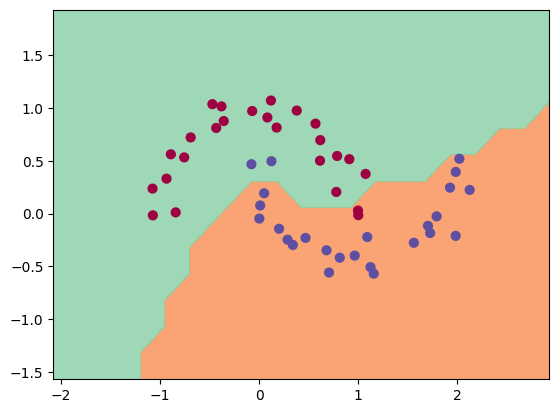

In [42]:
# visualize decision boundary

# TODO fix this, scales are all off and net outputs with dim2
amax = lambda x: x[0].data > x[1].data

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
logits = [net(i) for i in inputs]
Z = np.array([l[0].data > l[1].data for l in logits])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
